# Additional EDA

This Notebook will describe additional EDA and engineering done on the data with the objective of answering the following questions:

* Which sector should you be looking at? and what price per square foot will you get?
* Should you be looking at the waterfront or in-land?
* Should you invest in new or older properties?
* How many bedrooms should you be looking at?
* How many bathrooms should you be looking for?

This dataset was cleaned in a separate Notebook and once done, a final cutoff of 1 million dollars was applied. Look at the "Cleaning" document for details

I will start this document by importing the necessary libraries, followed by the data loading and then going into detail by questions. 

## Libraries

In [59]:
import  pandas as pd
import  numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap

%matplotlib inline
sns.set_style('darkgrid')

In [60]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [3]:
df3 = pd.read_csv('df3.csv', index_col=0)
pd.set_option('display.max_columns', 500) # Allows to display up to 500 columns
df3.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sale,year_sale,renovation,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_B,Grade_C,Grade_D,home_age
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,2014,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,65
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,12,2014,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,2,2015,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,87
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12,2014,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,2015,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,33


# Question 1

The first variable/feature that I want to look at is the sector. Which would be the best sector to invest in with regards to the price per square foot? meaning where will the investors seems to get more for their money?

In order to answer this question, I will look at the final dataframe cleaned and filtered by the model. 

The sectors are data engineered based on the latitude and longitude values given. As it was stated earlier on the other notebooks, it is clear to me that the Zip Codes are controlling the price, but we have decided to simplify this problem and as a first pass solution we are looking at 4 sectors. 

Before I start with the EDA and further engineering, I just want to remind the readers that the I applied a final filter for the data with a threshold of 1,000,000 Dollar, therefore the number of samples/homes has been reduced but not too significantly.

In [4]:
dfq1 = df3[['price', 'sqft_living', 'sqft_living15', 'lat', 'long']]

In [5]:
dfq1.head()

,price,sqft_living,sqft_living15,lat,long
0,221900.0,1180,1340,47.5112,-122.257
1,538000.0,2570,1690,47.7210,-122.319
2,180000.0,770,2720,47.7379,-122.233
3,604000.0,1960,1360,47.5208,-122.393
4,510000.0,1680,1800,47.6168,-122.045


## EDA & Engineering 

below is the sector recreation as it was done on the previous notebook for the modeling. This time it is slightly different. Now I'm putting the sector numbers in a single sector column so that the prices and square footage can be used for groupby.

In [6]:
dfq1.loc[(dfq1['lat'] >= 47.5 ) & (dfq1['long'] < -122.3), "sector"] = 1
dfq1.loc[(dfq1['lat'] >= 47.5 ) & (dfq1['long'] > -122.3), "sector"] = 2
dfq1.loc[(dfq1['lat'] < 47.5 ) & (dfq1['long'] > -122.3), "sector"] = 3
dfq1.loc[(dfq1['lat'] < 47.5 ) & (dfq1['long'] < -122.3), "sector"] = 4

In [7]:
dfq1.head()

,price,sqft_living,sqft_living15,lat,long,sector
0,221900.0,1180,1340,47.5112,-122.257,2.0
1,538000.0,2570,1690,47.7210,-122.319,1.0
2,180000.0,770,2720,47.7379,-122.233,2.0
3,604000.0,1960,1360,47.5208,-122.393,1.0
4,510000.0,1680,1800,47.6168,-122.045,2.0


In [8]:
dfq1.sector.value_counts()

2.0    8165
1.0    5480
3.0    4899
4.0    1586
Name: sector, dtype: int64

With the sectors created and checked, I will proceed to drop the lat and long columns:

In [9]:
dfq1.drop(['lat','long'], axis=1, inplace=True)

In [10]:
dfq1.head()

,price,sqft_living,sqft_living15,sector
0,221900.0,1180,1340,2.0
1,538000.0,2570,1690,1.0
2,180000.0,770,2720,2.0
3,604000.0,1960,1360,1.0
4,510000.0,1680,1800,2.0


The next step will be to groupby sector and at the same time, calculate the mean of the other columns and round the values to 2 decimals:

In [11]:
dfq1 = dfq1.groupby(['sector']).mean().round(2)
dfq1.reset_index(inplace=True)
dfq1.head()

,sector,price,sqft_living,sqft_living15
0,1.0,505438.50,1661.59,1581.48
1,2.0,575834.19,2208.68,2180.60
2,3.0,331316.47,1981.53,1919.57
3,4.0,324299.67,1861.76,1805.93


Now with the square foot average of living (sqft_living) and the average price (price), I will calculate the average price per square foot for each sector:

In [12]:
dfq1['sqft_avg_price'] = (dfq1['price']/dfq1['sqft_living']).round(2)
dfq1.head()

,sector,price,sqft_living,sqft_living15,sqft_avg_price
0,1.0,505438.50,1661.59,1581.48,304.19
1,2.0,575834.19,2208.68,2180.60,260.71
2,3.0,331316.47,1981.53,1919.57,167.20
3,4.0,324299.67,1861.76,1805.93,174.19


I did some research on the average square footage of homes in Seattle for a Middle Class and came up with 2000 to 3000 for 2019. To simplify our plots I will use the mean of those values, meaning 2500 square feet to give me the average price for houses with that footage.

In [13]:
dfq1['2500_sqft'] = dfq1['sqft_avg_price']*2500
dfq1.head()

,sector,price,sqft_living,sqft_living15,sqft_avg_price,2500_sqft
0,1.0,505438.50,1661.59,1581.48,304.19,760475.0
1,2.0,575834.19,2208.68,2180.60,260.71,651775.0
2,3.0,331316.47,1981.53,1919.57,167.20,418000.0
3,4.0,324299.67,1861.76,1805.93,174.19,435475.0


The plot that I'm about to do with try to illustrate the price peer square foot classified by sectors and the color coding will correspond to the average price

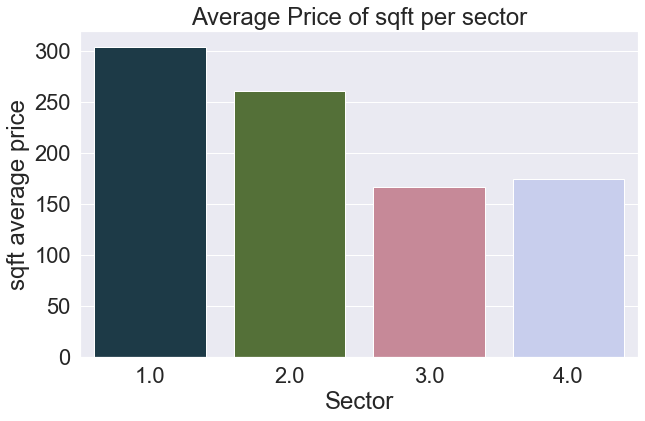

In [14]:
#plt.rcParams["axes.labelsize"] = 20
#plt.rcParams["axes.titlesize"] = 20
sns.set(font_scale = 2)

plt.figure(figsize=(10,6))

chart1 = sns.barplot(x='sector', y='sqft_avg_price', data=dfq1, palette="cubehelix")

#From here onwards it is all about make up for the plots

chart1.set_xticklabels(chart1.get_xticklabels())
chart1.set(xlabel='Sector',ylabel='sqft average price', title='Average Price of sqft per sector')
chart1.grid(b=True, which='major', axis='y')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

<b>Observations</b>

* Interesting enough Sector 1 has the highest sqft average price when I was expecting this from Sector 2. However by putting a price threshold at 1.0 million dollars, this has filtered out many of the priciest homes and therefore had probably affected the final result. However because the investors are looking not to pass this value range, I will preserve these results. 

* By looking at the sqft_living average per sector, it is clear how the biggest houses are in the sector 2, where the majority of the homes have a waterfront, but the priciest square foot is on sector 1, probably because the houses are smaller and the prices, even when they decrease

* The smallest homes are in sector 4, but for the average middle class the cheapest price is on sector 3. 

* Based on this plot it seems smarter to invest on sector 1, but lets see at the rest of the analysis to come up with a final and more robust conclusion.

# Question 2

Now I will try to address the number of bedrooms. How many bedrooms should the investors be looking for? and if there is a cutoff value where the price trend changes?

In [15]:
df3.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sale,year_sale,renovation,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_B,Grade_C,Grade_D,home_age
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,2014,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,65
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,12,2014,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,2,2015,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,87
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12,2014,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,2015,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,33


## EDA & Engineering 

I will have to do a bit more data engineering to come up with a new dataframe that has the average price related to the number of bedrooms per sectors. This won't be hard though as the data has been all cleaned, so a simple group by would do the trick

In order to be able to make a proper recommendation in terms of bedrooms, even when the investors are looking for a limited money range, I will need to look at both, the entire cleaned dataframe, and the cropped at 1 million dollars one. This way I will still be able to identify any possible trends per sector. 

First I will create a smaller dataframe from the originally cleaned df3 and re-create the sectors:

In [16]:
dfq2 = df3[['price', 'bedrooms', 'lat', 'long']]

In [17]:
dfq2.loc[(dfq2['lat'] >= 47.5 ) & (dfq2['long'] < -122.3), "sector"] = 1
dfq2.loc[(dfq2['lat'] >= 47.5 ) & (dfq2['long'] > -122.3), "sector"] = 2
dfq2.loc[(dfq2['lat'] < 47.5 ) & (dfq2['long'] > -122.3), "sector"] = 3
dfq2.loc[(dfq2['lat'] < 47.5 ) & (dfq2['long'] < -122.3), "sector"] = 4

In [18]:
# Quick check to QC the dfq2:

dfq2.head()

,price,bedrooms,lat,long,sector
0,221900.0,3,47.5112,-122.257,2.0
1,538000.0,3,47.7210,-122.319,1.0
2,180000.0,2,47.7379,-122.233,2.0
3,604000.0,4,47.5208,-122.393,1.0
4,510000.0,3,47.6168,-122.045,2.0


In [19]:
dfq2.shape

(20240, 5)

I will now proceed once again to drop the 'lat' and 'long' columns:

In [20]:
dfq2.drop(['lat', 'long'], axis=1, inplace=True)

In [21]:
dfq2 = dfq2.groupby(['bedrooms', 'sector']).mean().round(2)
dfq2.reset_index(inplace=True)
dfq2.head()

,bedrooms,sector,price
0,1,1.0,332611.37
1,1,2.0,343144.68
2,1,3.0,233585.93
3,1,4.0,292837.50
4,2,1.0,422749.88


In [22]:
dfq2.shape

(35, 3)

In [23]:
dfq2.bedrooms.value_counts()

7     4
6     4
5     4
4     4
3     4
2     4
1     4
8     3
10    2
11    1
9     1
Name: bedrooms, dtype: int64

In [24]:
dfq2.shape

(35, 3)

In [25]:
# dfq2.head(50)
# I commented this line because of the number of rows. Feel free to uncomment to qc them

Now with the cleaned new dfq2 I will proceed to sdo the first plot with the data cropped at 1 million dollars:

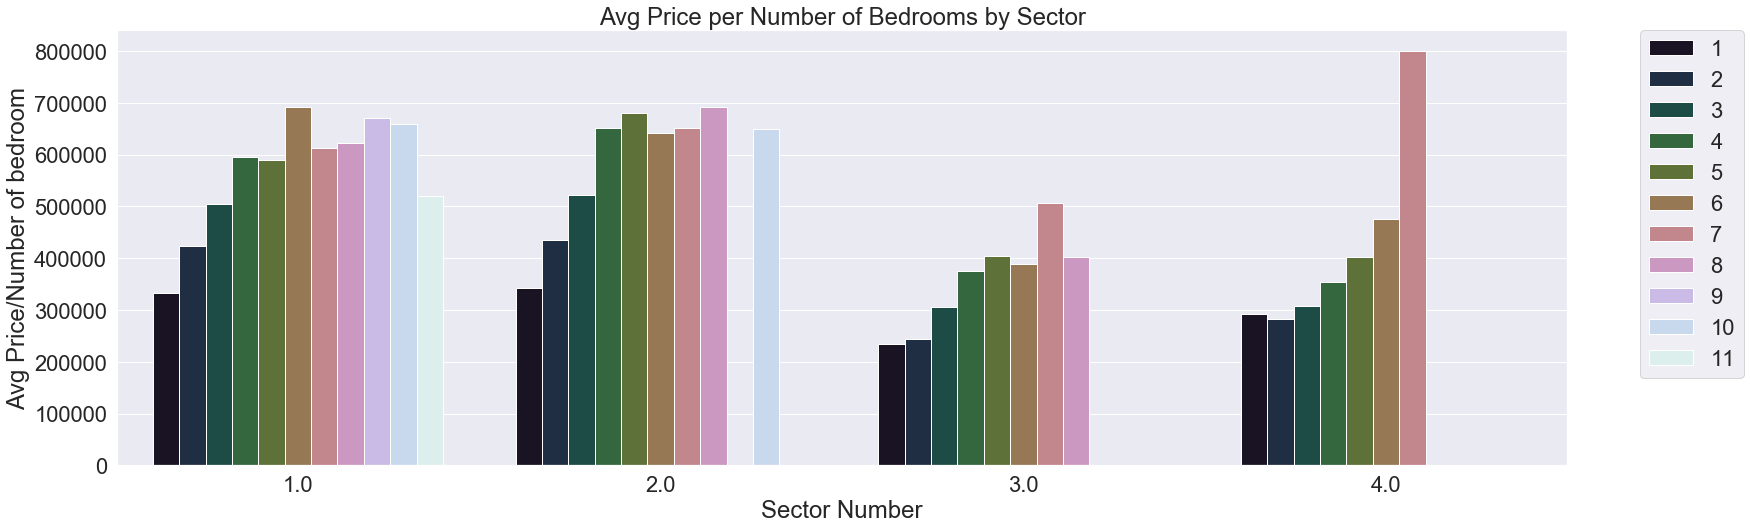

In [26]:
#plt.rcParams["axes.labelsize"] = 20
#plt.rcParams["axes.titlesize"] = 20
sns.set(font_scale = 2)

plt.figure(figsize=(26,8))
sns.barplot(x='sector', y='price', data=dfq2, hue='bedrooms', palette="cubehelix")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Avg Price per Number of Bedrooms by Sector')
plt.xlabel('Sector Number')
plt.ylabel('Avg Price/Number of bedroom')
plt.show()

Now I will need to load the cleaned data without the 1 million Dollar threshold and do the same exercise in order to convert it to an equivalent dataframe. Once this is done, I will proceed to make the same plot. Keep in mind that the labels on the y axis won't be the same as the data range will have increased even when we are looking at averages

In [27]:
dfq2_ad = pd.read_csv('df_cleaned_alldata.csv', index_col=0)

In [28]:
dfq2_ad.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sale,year_sale,renovation,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_B,Grade_C,Grade_D,home_age
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,2014,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,65
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,12,2014,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,2,2015,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,87
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12,2014,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,2015,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,33


In [29]:
dfq2_ad.shape

(21419, 32)

In [30]:
dfq2_ad = df3[['price', 'bedrooms', 'lat', 'long']]

In [31]:
dfq2_ad.head()

,price,bedrooms,lat,long
0,221900.0,3,47.5112,-122.257
1,538000.0,3,47.7210,-122.319
2,180000.0,2,47.7379,-122.233
3,604000.0,4,47.5208,-122.393
4,510000.0,3,47.6168,-122.045


In [32]:
dfq2_ad.shape

(20240, 4)

In [33]:
dfq2_ad.loc[(dfq2_ad['lat'] >= 47.5 ) & (dfq2_ad['long'] < -122.3), "sector"] = 1
dfq2_ad.loc[(dfq2_ad['lat'] >= 47.5 ) & (dfq2_ad['long'] > -122.3), "sector"] = 2
dfq2_ad.loc[(dfq2_ad['lat'] < 47.5 ) & (dfq2_ad['long'] > -122.3), "sector"] = 3
dfq2_ad.loc[(dfq2_ad['lat'] < 47.5 ) & (dfq2_ad['long'] < -122.3), "sector"] = 4

In [34]:
dfq2_ad.head()

,price,bedrooms,lat,long,sector
0,221900.0,3,47.5112,-122.257,2.0
1,538000.0,3,47.7210,-122.319,1.0
2,180000.0,2,47.7379,-122.233,2.0
3,604000.0,4,47.5208,-122.393,1.0
4,510000.0,3,47.6168,-122.045,2.0


In [35]:
dfq2_ad.drop(['lat', 'long'], axis=1, inplace=True)

In [36]:
dfq2_ad = dfq2_ad.groupby(['bedrooms', 'sector']).mean().round(2)
dfq2_ad.reset_index(inplace=True)
dfq2_ad.head()

,bedrooms,sector,price
0,1,1.0,332611.37
1,1,2.0,343144.68
2,1,3.0,233585.93
3,1,4.0,292837.50
4,2,1.0,422749.88


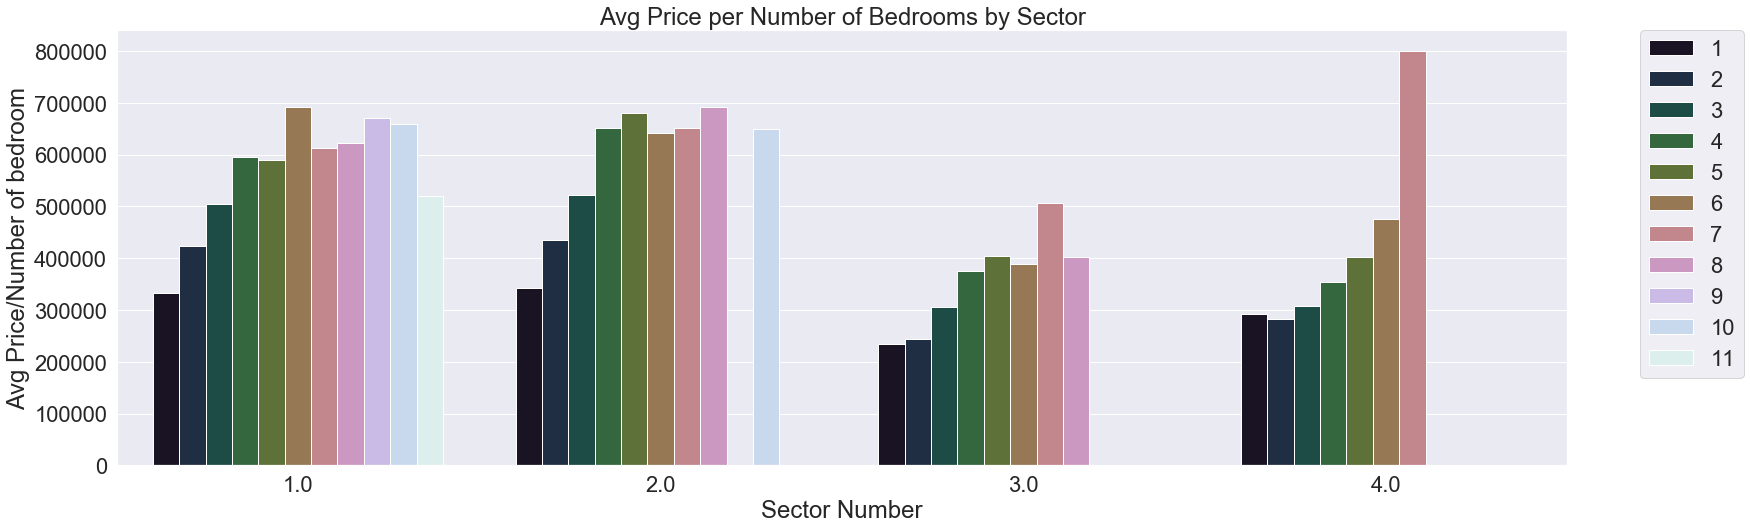

In [37]:
#plt.rcParams["axes.labelsize"] = 20
#plt.rcParams["axes.titlesize"] = 20
sns.set(font_scale = 2)

plt.figure(figsize=(26,8))
sns.barplot(x='sector', y='price', data=dfq2_ad, hue='bedrooms', palette="cubehelix")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Avg Price per Number of Bedrooms by Sector')
plt.xlabel('Sector Number')
plt.ylabel('Avg Price/Number of bedroom')
plt.show()

# Question 3

Here I will try look at the waterfront. I already know from the Linear Regression Model that it doesn't offer much in terms or being a predictive variable. Maybe this is due to the low number within that sample compared to the inland properties. Keep in mind that inland is referring to properties with no waterfront view, and not properly located in the waterfront.

For this purpose I will have to engineer again the sectors, but this time is direct as it is done above, and also I will have to get more information from the original dataframe.

Not much more to explain here but just to proceed with a similar workflow as the other variables above:

In [38]:
dfq3 = df3[['price', 'lat', 'long', 'waterfront', 'sqft_living']]
dfq3.head()

,price,lat,long,waterfront,sqft_living
0,221900.0,47.5112,-122.257,0.0,1180
1,538000.0,47.7210,-122.319,0.0,2570
2,180000.0,47.7379,-122.233,0.0,770
3,604000.0,47.5208,-122.393,0.0,1960
4,510000.0,47.6168,-122.045,0.0,1680


## EDA & Engineering 

In [39]:
dfq3.loc[(dfq3['lat'] >= 47.5 ) & (dfq3['long'] < -122.3), "sector"] = 1
dfq3.loc[(dfq3['lat'] >= 47.5 ) & (dfq3['long'] > -122.3), "sector"] = 2
dfq3.loc[(dfq3['lat'] < 47.5 ) & (dfq3['long'] > -122.3), "sector"] = 3
dfq3.loc[(dfq3['lat'] < 47.5 ) & (dfq3['long'] < -122.3), "sector"] = 4

In [40]:
dfq3.drop(['lat', 'long'], axis=1, inplace=True)

In [41]:
dfq3.head()

,price,waterfront,sqft_living,sector
0,221900.0,0.0,1180,2.0
1,538000.0,0.0,2570,1.0
2,180000.0,0.0,770,2.0
3,604000.0,0.0,1960,1.0
4,510000.0,0.0,1680,2.0


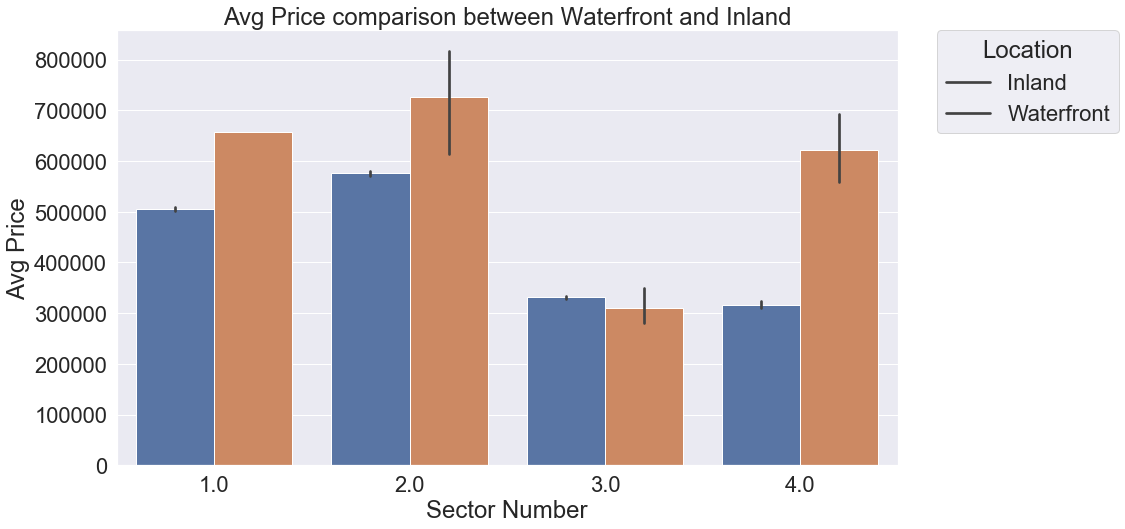

In [42]:
sns.set(font_scale = 2)

plt.figure(figsize=(14,8))
sns.barplot(x='sector', y='price', data=dfq3, hue='waterfront')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc=2, labels=['Inland', 'Waterfront'], borderaxespad=0.)
plt.title('Avg Price comparison between Waterfront and Inland')
plt.xlabel('Sector Number')
plt.ylabel('Avg Price')
plt.show()

# Question 4

This will be a similar approach than the one for the bedrooms with the difference that sub-groups will be created for the bathrooms as there are many that are not round numbers. For details of this look at the creation of the No_bathrooms below which stands for Number of bathrooms, and not, 'no' bathrooms. 

In [43]:
dfq4 = df3[['price', 'lat', 'long', 'bathrooms', 'sqft_living']]

## EDA & Engineering 

In [44]:
dfq4.loc[(dfq4['lat'] >= 47.5 ) & (dfq4['long'] < -122.3), "sector"] = 1
dfq4.loc[(dfq4['lat'] >= 47.5 ) & (dfq4['long'] > -122.3), "sector"] = 2
dfq4.loc[(dfq4['lat'] < 47.5 ) & (dfq4['long'] > -122.3), "sector"] = 3
dfq4.loc[(dfq4['lat'] < 47.5 ) & (dfq4['long'] < -122.3), "sector"] = 4

In [45]:
dfq4.drop(['lat', 'long'], axis=1, inplace=True)
dfq4.head()

,price,bathrooms,sqft_living,sector
0,221900.0,1.00,1180,2.0
1,538000.0,2.25,2570,1.0
2,180000.0,1.00,770,2.0
3,604000.0,3.00,1960,1.0
4,510000.0,2.00,1680,2.0


In [46]:
dfq4.bathrooms.value_counts()

2.50    5164
1.00    3792
1.75    2986
2.25    1942
2.00    1892
1.50    1415
2.75    1101
3.00     659
3.50     537
3.25     420
3.75      82
4.00      70
0.75      70
4.50      50
4.25      28
5.00       8
1.25       7
4.75       5
0.50       4
5.25       3
6.00       1
7.50       1
5.50       1
6.75       1
5.75       1
Name: bathrooms, dtype: int64

These are too many rows to work with if I am going to assess bathrooms per sector. As a solution I will generate categories, with round numbers: 1, 2, 3, 4, 5, 6 and 7 bathrooms

In [47]:
dfq4.loc[(dfq4['bathrooms'] > 0) & (dfq4['bathrooms'] <= 1.5), "No_bathrooms"] = 1
dfq4.loc[(dfq4['bathrooms'] > 1.5) & (dfq4['bathrooms'] <= 2.5), "No_bathrooms"] = 2 
dfq4.loc[(dfq4['bathrooms'] > 2.5) & (dfq4['bathrooms'] <= 3.5), "No_bathrooms"] = 3
dfq4.loc[(dfq4['bathrooms'] > 3.5) & (dfq4['bathrooms'] <= 4.5), "No_bathrooms"] = 4
dfq4.loc[(dfq4['bathrooms'] > 4.5) & (dfq4['bathrooms'] <= 5.5), "No_bathrooms"] = 5
dfq4.loc[(dfq4['bathrooms'] > 5.5) & (dfq4['bathrooms'] <= 6.5), "No_bathrooms"] = 6
dfq4.loc[(dfq4['bathrooms'] > 6.5) & (dfq4['bathrooms'] <= 7.5), "No_bathrooms"] = 7


In [48]:
dfq4.head()

,price,bathrooms,sqft_living,sector,No_bathrooms
0,221900.0,1.00,1180,2.0,1.0
1,538000.0,2.25,2570,1.0,2.0
2,180000.0,1.00,770,2.0,1.0
3,604000.0,3.00,1960,1.0,3.0
4,510000.0,2.00,1680,2.0,2.0


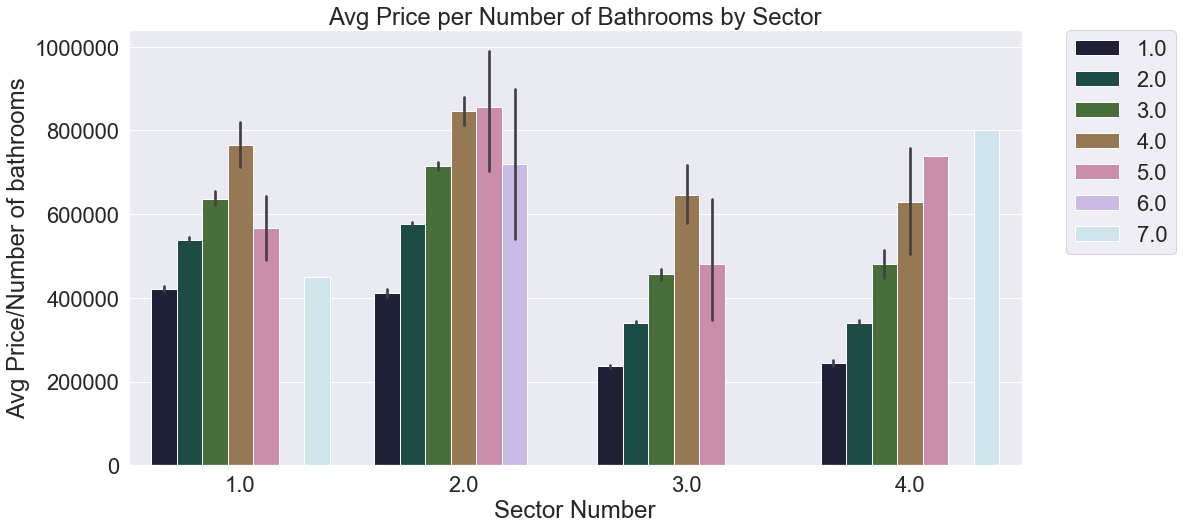

In [49]:
sns.set(font_scale = 2)

plt.figure(figsize=(16,8))
sns.barplot(x='sector', y='price', data=dfq4, hue='No_bathrooms', palette="cubehelix")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Avg Price per Number of Bathrooms by Sector')
plt.xlabel('Sector Number')
plt.ylabel('Avg Price/Number of bathrooms')
plt.show()

Overall there seems to be a magic number for the numbers of bathrooms. Based on our data, which has been cut to 1,000,000 Dollars, that number is 4. After 4 bathrooms the plots above suggest that the home price in average decreases with the exception of sector 4. It is believe after looking at the data that those two high values (5 and 7) are outliers that were missed during the cleaning, but if properly cleaned this would align with the rest of the models.

# Question 5

Home age is an engineer variable which proved not to be predictive when it comes to home price. However, it was decided that it was worth a look at its numbers again as we thought that very modern homes will be ore expensive, but also some of the older typical houses would be expensive. We will wait for the results below to see if this assumptions were correct.

There will be a little bit of engineering again here. The code will be the same just with modified values.

In [50]:
dfq5 = df3[['price', 'home_age', 'lat', 'long', 'sqft_living']]
dfq5.head()

,price,home_age,lat,long,sqft_living
0,221900.0,65,47.5112,-122.257,1180
1,538000.0,69,47.7210,-122.319,2570
2,180000.0,87,47.7379,-122.233,770
3,604000.0,55,47.5208,-122.393,1960
4,510000.0,33,47.6168,-122.045,1680


## EDA & Engineering 

In [51]:
dfq5.shape

(20240, 5)

In [52]:
dfq5.loc[(dfq5['home_age'] > 0) & (dfq5['home_age'] <= 10), "age_range"] = 1
dfq5.loc[(dfq5['home_age'] >= 11) & (dfq5['home_age'] <= 20), "age_range"] = 2 
dfq5.loc[(dfq5['home_age'] >= 21) & (dfq5['home_age'] <= 30), "age_range"] = 3
dfq5.loc[(dfq5['home_age'] >= 31) & (dfq5['home_age'] <= 40), "age_range"] = 4
dfq5.loc[(dfq5['home_age'] >= 41) & (dfq5['home_age'] <= 50), "age_range"] = 5
dfq5.loc[(dfq5['home_age'] >= 51) & (dfq5['home_age'] <= 60), "age_range"] = 6
dfq5.loc[(dfq5['home_age'] >= 61) & (dfq5['home_age'] <= 70), "age_range"] = 7
dfq5.loc[(dfq5['home_age'] >= 71) & (dfq5['home_age'] <= 80), "age_range"] = 8
dfq5.loc[(dfq5['home_age'] >= 81) & (dfq5['home_age'] <= 90), "age_range"] = 9
dfq5.loc[(dfq5['home_age'] >= 91) & (dfq5['home_age'] <= 100), "age_range"] = 10
dfq5.loc[(dfq5['home_age'] >= 101) & (dfq5['home_age'] <= 110), "age_range"] = 11
dfq5.loc[(dfq5['home_age'] >= 111) & (dfq5['home_age'] <= 120), "age_range"] = 12

In [53]:
dfq5.home_age.value_counts()

6      509
15     423
14     407
43     403
16     401
      ... 
119     28
118     24
85      22
87      21
86      19
Name: home_age, Length: 116, dtype: int64

In [54]:
dfq5.head()

,price,home_age,lat,long,sqft_living,age_range
0,221900.0,65,47.5112,-122.257,1180,7.0
1,538000.0,69,47.7210,-122.319,2570,7.0
2,180000.0,87,47.7379,-122.233,770,9.0
3,604000.0,55,47.5208,-122.393,1960,6.0
4,510000.0,33,47.6168,-122.045,1680,4.0


In [55]:
dfq5.age_range.value_counts()

2.0     3219
6.0     2535
7.0     2318
5.0     2191
4.0     2164
3.0     2066
8.0     1691
1.0     1146
10.0    1111
11.0     749
12.0     585
9.0      465
Name: age_range, dtype: int64

In [56]:
dfq5.loc[(dfq5['lat'] >= 47.5 ) & (dfq5['long'] < -122.3), "sector"] = 1
dfq5.loc[(dfq5['lat'] >= 47.5 ) & (dfq5['long'] > -122.3), "sector"] = 2
dfq5.loc[(dfq5['lat'] < 47.5 ) & (dfq5['long'] > -122.3), "sector"] = 3
dfq5.loc[(dfq5['lat'] < 47.5 ) & (dfq5['long'] < -122.3), "sector"] = 4

In [57]:
dfq5.drop(['lat', 'long'], axis=1, inplace=True)
dfq5.head()

,price,home_age,sqft_living,age_range,sector
0,221900.0,65,1180,7.0,2.0
1,538000.0,69,2570,7.0,1.0
2,180000.0,87,770,9.0,2.0
3,604000.0,55,1960,6.0,1.0
4,510000.0,33,1680,4.0,2.0


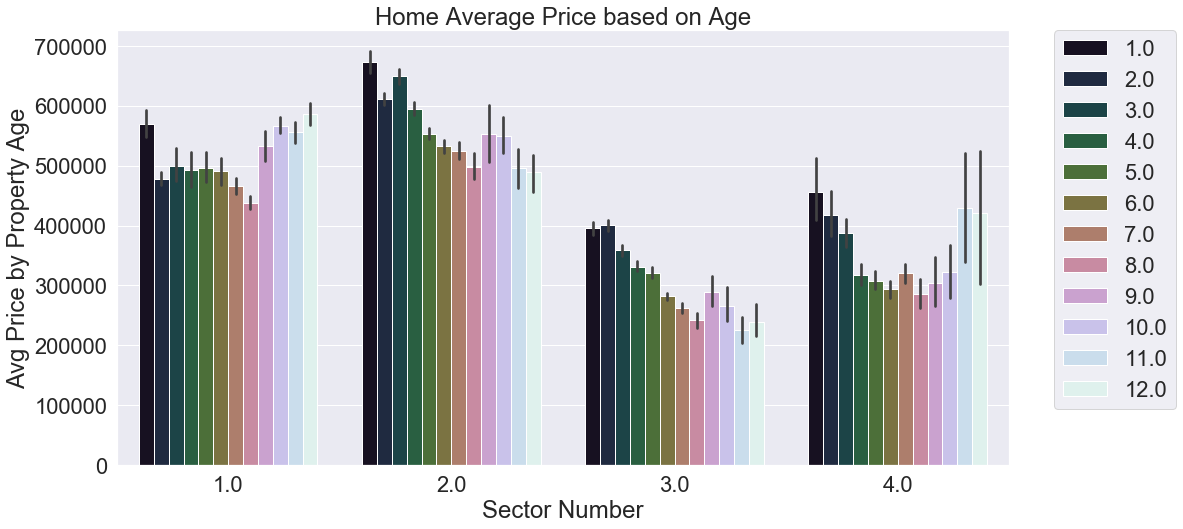

In [61]:
sns.set(font_scale = 2)

plt.figure(figsize=(16,8))
sns.barplot(x='sector', y='price', data=dfq5, hue='age_range', palette="cubehelix")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Home Average Price based on Age')
plt.xlabel('Sector Number')
plt.ylabel('Avg Price by Property Age')
plt.show()

Our predictions seem to be correct up to a certain point. Sector 1 clearly has that trend were recent and old houses are the most expensive ones, as well ass sector 4. Sector 2 might be biased by the data itself as we cropped the most expensive homes by putting our threshold at 1,000,000 dollars, so maybe it still happens there. Finally sector 3 might be suffering of a similar effect as sector 2. 

In average I think that it is save to say that at least the most modern houses (between 1 to 10 years old) are the most expensive.